<a href="https://colab.research.google.com/github/MichelaMarini/MATH-6373-PyTorch-tutorial/blob/main/WEEK_6_UNET_DENOISING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# --------------------------
# 1. Import Required Libraries
# --------------------------

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import glob
import numpy as np
import matplotlib.pyplot as plt

# Path to data in Google Drive
data_path = "/content/drive/My Drive/CT_data"
train_path = os.path.join(data_path, "train")
test_path = os.path.join(data_path, "test")

# Verify paths
assert os.path.exists(train_path), "Train folder not found!"
assert os.path.exists(test_path), "Test folder not found!"


Mounted at /content/drive


In [16]:
# --------------------------
# 2. Custom Dataset Class for CT Data
# --------------------------
# This class loads pairs of images:
#  - A "clean" (original) CT image.
#  - A "noisy" CT image (with added noise).
class CTDataset(Dataset):
    def __init__(self, img_folder, noisy_folder, transform=None):
        # Find all .jpg files in the clean image folder
        self.img_paths = sorted(glob.glob(os.path.join(img_folder, "*.jpg")))
        # Find all .jpg files in the noisy image folder
        self.noisy_paths = sorted(glob.glob(os.path.join(noisy_folder, "*.jpg")))
        # Store the transform (if any) to apply to the images
        self.transform = transform

    def __len__(self):
        # Return the total number of images in the dataset
        return len(self.img_paths)

    def __getitem__(self, idx):
        # Open the clean image and convert it to grayscale ("L")
        clean_img = Image.open(self.img_paths[idx]).convert("L")
        # Open the corresponding noisy image and convert it to grayscale
        noisy_img = Image.open(self.noisy_paths[idx]).convert("L")

        # If a transformation is provided (e.g., converting to tensor, normalization), apply it
        if self.transform:
            clean_img = self.transform(clean_img)
            noisy_img = self.transform(noisy_img)

        # Return a tuple: (noisy image as input, clean image as target)
        return noisy_img, clean_img

# --------------------------
# 3. Define Transformations
# --------------------------
# Convert images to PyTorch tensors and normalize them to the range [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # (x - 0.5) / 0.5 => range [-1, 1]
])

# --------------------------
# 4. Load the Dataset from Google Drive
# --------------------------
# Assume that 'train_path' and 'test_path' are defined paths to your CT_data folders.
# For example, if your CT_data folder is mounted from Google Drive:
# train_path = "/content/drive/My Drive/CT_data/train"
# test_path = "/content/drive/My Drive/CT_data/test"

# Create training and test datasets by specifying the folder paths
train_dataset = CTDataset(os.path.join(train_path, "img"), os.path.join(train_path, "img_0.01"), transform=transform)
test_dataset = CTDataset(os.path.join(test_path, "img"), os.path.join(test_path, "img_0.01"), transform=transform)

# --------------------------
# 5. Visualize a Sample from the CT Data
# --------------------------
# This is to give you an idea of what the data looks like.
sample_noisy, sample_clean = train_dataset[0]
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(sample_noisy.squeeze(), cmap='gray')
plt.title("Noisy CT Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(sample_clean.squeeze(), cmap='gray')
plt.title("Clean CT Image")
plt.axis("off")

plt.show()

# --------------------------
# 6. Split the Dataset into Validation and Test Sets
# --------------------------
# In this example, we split the test_dataset into:
#   - 95% for validation
#   - 5% for testing
val_size = int(0.95 * len(test_dataset))
test_size = len(test_dataset) - val_size
val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size])

# --------------------------
# 7. Create DataLoaders
# --------------------------
# DataLoaders help to iterate over the dataset in batches.
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Print the number of images in each set
print(f"Train: {len(train_loader.dataset)}, Val: {len(val_loader.dataset)}, Test: {len(test_loader.dataset)}")

# --------------------------
# 8. Define the UNet Model for Denoising
# --------------------------
# The UNet model here is based on an encoder-decoder architecture:
#   - The encoder extracts features from the input image.
#   - The decoder reconstructs the image from the encoded features.
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder: increasing the number of feature maps while reducing spatial dimensions.
        self.encoder = nn.Sequential(
            # First two convolutions: input 1 channel to 128 feature maps.
            nn.Conv2d(in_channels, 128, kernel_size=3, padding=1),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Downsampling: halves the spatial dimensions.
            # Next two convolutions: from 128 to 256 feature maps.
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Decoder: reduces the number of feature maps and upsamples the spatial dimensions.
        self.decoder = nn.Sequential(
            # Convolution: reducing from 256 to 128 feature maps.
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # Transposed convolution for upsampling (increasing spatial dimensions).
            nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2),
            # Final convolution to get the desired number of output channels (1 for grayscale).
            nn.Conv2d(128, out_channels, kernel_size=1)
        )

    # The forward() method defines the data flow through the network.
    def forward(self, x):
        x = self.encoder(x)  # Pass input through the encoder.
        x = self.decoder(x)  # Pass encoded features through the decoder.
        return x

# --------------------------
# 9. Setup for Training the Model
# --------------------------
# Choose the device (GPU if available, otherwise CPU).
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Initialize the UNet model for grayscale images (1 input channel and 1 output channel).
model = UNet(in_channels=1, out_channels=1).to(device)

# Define the loss function: L1Loss (mean absolute error), which tends to preserve details.
criterion = nn.L1Loss()

# Define the optimizer: Adam with a learning rate of 1e-3.
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# --------------------------
# 10. Define the Training Function
# --------------------------
def train_model(model, train_loader, val_loader, epochs=10):
    best_loss = float("inf")  # Initialize the best validation loss to infinity.
    for epoch in range(epochs):
        model.train()  # Set the model to training mode.
        train_loss = 0.0  # Variable to accumulate the training loss.

        # Iterate over the training data in batches.
        for noisy_imgs, clean_imgs in train_loader:
            # Move images to the selected device (GPU or CPU).
            noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)

            optimizer.zero_grad()  # Reset gradients.
            outputs = model(noisy_imgs)  # Forward pass: get model outputs for the noisy images.
            loss = criterion(outputs, clean_imgs)  # Compute the loss comparing output with the clean image.
            loss.backward()  # Backpropagate the loss to compute gradients.
            optimizer.step()  # Update the model weights.

            train_loss += loss.item()  # Accumulate the loss for this batch.

        # Compute the average training loss for the epoch.
        train_loss /= len(train_loader)

        # --------------------------
        # Validation Phase (No weight updates)
        # --------------------------
        model.eval()  # Set the model to evaluation mode.
        val_loss = 0.0  # Variable to accumulate the validation loss.
        with torch.no_grad():  # No gradient computation during validation.
            for noisy_imgs, clean_imgs in val_loader:
                noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
                outputs = model(noisy_imgs)
                val_loss += criterion(outputs, clean_imgs).item()  # Accumulate validation loss.

        # Compute the average validation loss for the epoch.
        val_loss /= len(val_loader)

        # Print the training and validation loss for the current epoch.
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Save the model if the validation loss is the best we've seen so far.
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), "/content/drive/My Drive/CT_data/best_unet.pth")
            print("Saved Best Model!")

# --------------------------
# 11. Train the Model
# --------------------------
train_model(model, train_loader, val_loader, epochs=10)

Train: 400, Val: 95, Test: 5
Using device: cuda
Epoch 1/10, Train Loss: 0.3701, Val Loss: 0.1944
Saved Best Model!
Epoch 2/10, Train Loss: 0.1466, Val Loss: 0.1390
Saved Best Model!
Epoch 3/10, Train Loss: 0.1163, Val Loss: 0.1065
Saved Best Model!
Epoch 4/10, Train Loss: 0.1149, Val Loss: 0.0881
Saved Best Model!
Epoch 5/10, Train Loss: 0.0972, Val Loss: 0.0693
Saved Best Model!
Epoch 6/10, Train Loss: 0.0865, Val Loss: 0.0864
Epoch 7/10, Train Loss: 0.1002, Val Loss: 0.0616
Saved Best Model!
Epoch 8/10, Train Loss: 0.0945, Val Loss: 0.0674
Epoch 9/10, Train Loss: 0.0920, Val Loss: 0.1104
Epoch 10/10, Train Loss: 0.1005, Val Loss: 0.0670


<ipython-input-18-24ea501926bd>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/My Drive/CT_data/best_unet.pth"))


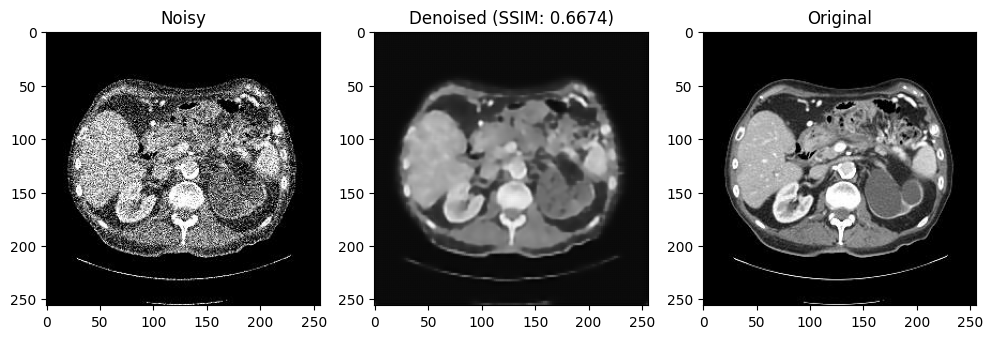

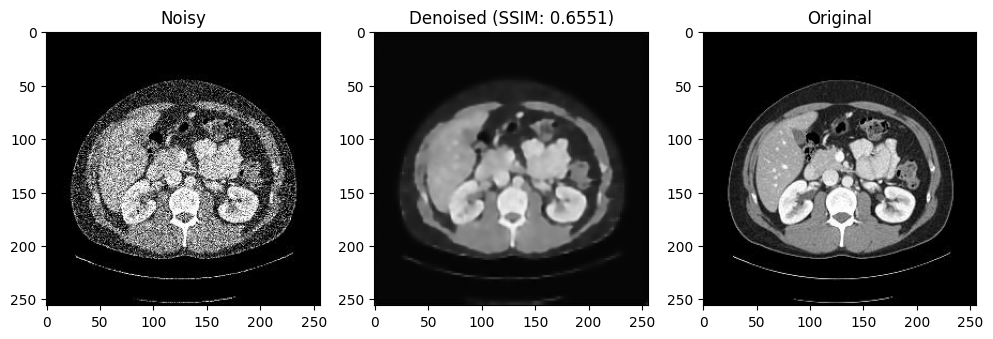

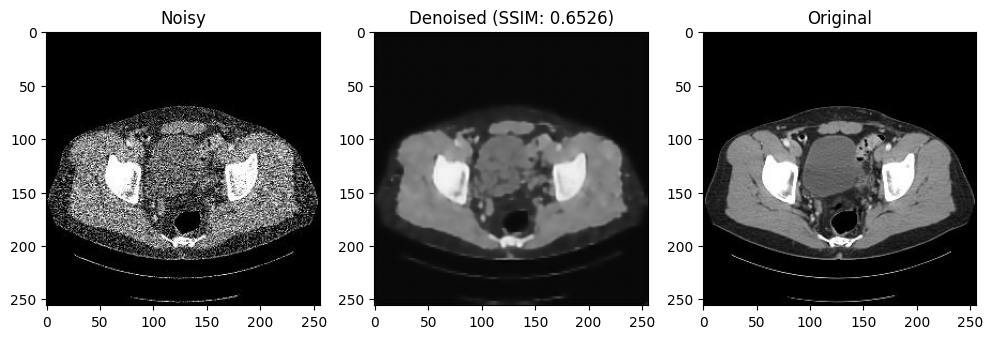

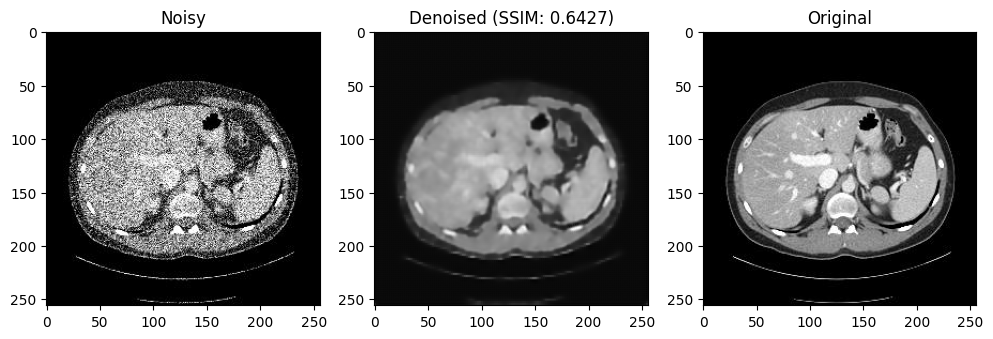

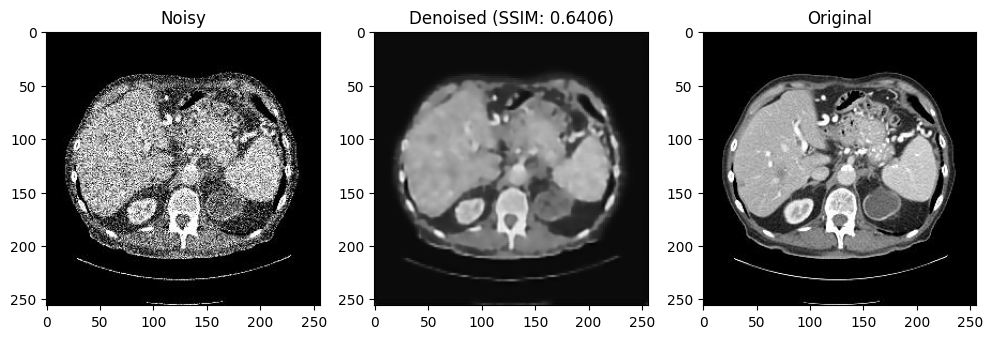

Average SSIM Score: 0.6517


In [18]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

# -----------------------------------------------------------
# Load the Best Model
# -----------------------------------------------------------
# Load the best performing model's parameters (state_dict) from the saved file.
model.load_state_dict(torch.load("/content/drive/My Drive/CT_data/best_unet.pth"))
# Ensure the model is on the correct device (GPU or CPU) for inference.
model.to(device)

# -----------------------------------------------------------
# Define the Test Function with SSIM Evaluation
# -----------------------------------------------------------
def test_model(model, test_loader):
    # Set the model to evaluation mode. This disables layers like dropout and ensures batch normalization works in inference mode.
    model.eval()
    # This list will store the SSIM scores for every image processed.
    all_ssim_scores = []

    # Disable gradient computations to speed up inference and reduce memory usage.
    with torch.no_grad():
        # Loop over the test dataset in batches.
        for noisy_imgs, clean_imgs in test_loader:
            # Move the noisy and clean images to the chosen device.
            noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
            # Run the model on the noisy images to obtain denoised outputs.
            outputs = model(noisy_imgs)

            # -----------------------------------------------------------
            # Convert PyTorch Tensors to NumPy Arrays for SSIM Calculation
            # -----------------------------------------------------------
            # .cpu() moves tensors to the CPU; .squeeze() removes dimensions of size 1,
            # and .numpy() converts them into NumPy arrays, which are required for the SSIM function.
            noisy_np = noisy_imgs.cpu().squeeze().numpy()
            denoised_np = outputs.cpu().squeeze().numpy()
            clean_np = clean_imgs.cpu().squeeze().numpy()

            # -----------------------------------------------------------
            # Compute SSIM for Each Image in the Batch
            # -----------------------------------------------------------
            # SSIM (Structural Similarity Index) is a perceptual metric that measures the similarity between two images.
            # It compares local patterns of pixel intensities normalized for luminance and contrast.
            # A score of 1 indicates perfect similarity, and values closer to 0 indicate less similarity.
            batch_ssim_scores = [
                ssim(denoised_np[i], clean_np[i], data_range=1.0)
                for i in range(len(denoised_np))
            ]
            # Add the batch's SSIM scores to the overall list.
            all_ssim_scores.extend(batch_ssim_scores)

            # -----------------------------------------------------------
            # Display Images and Their SSIM Scores
            # -----------------------------------------------------------
            # For each image in the current batch, create a figure showing:
            #   - The noisy input image.
            #   - The denoised output image, with its SSIM score shown in the title.
            #   - The original clean image.
            for i in range(len(denoised_np)):
                fig, axes = plt.subplots(1, 3, figsize=(12, 4))
                axes[0].imshow(noisy_np[i], cmap="gray")
                axes[0].set_title("Noisy")
                axes[1].imshow(denoised_np[i], cmap="gray")
                axes[1].set_title(f"Denoised (SSIM: {batch_ssim_scores[i]:.4f})")
                axes[2].imshow(clean_np[i], cmap="gray")
                axes[2].set_title("Original")
                plt.show()

    # -----------------------------------------------------------
    # Compute and Print the Average SSIM Score
    # -----------------------------------------------------------
    # Calculate the average SSIM score across all images.
    avg_ssim = np.mean(all_ssim_scores)
    print(f"Average SSIM Score: {avg_ssim:.4f}")

# -----------------------------------------------------------
# Test the Model
# -----------------------------------------------------------
# Run the test function using the test_loader to evaluate and visualize the model's performance.
test_model(model, test_loader)

# Exercise:

In this task, you will work on a denoising problem using the MNIST dataset. Your task is to simulate salt and pepper noise on MNIST images, then define and train a UNet model to restore the original images. Here's what you need to do:

**Implement a UNet model that takes in a noisy grayscale image and outputs a denoised image.**
Ensure that your model is properly designed with an encoder (to extract features) and a decoder (to reconstruct the image).
Train the Model:

**Use the training data (noisy-clean image pairs) to train your UNet model.**
Train your model for 10 epochs.
Use an appropriate loss function (e.g., L1 Loss) and an optimizer (e.g., Adam).
Test the Model:

**After training, evaluate your model on the test set.**
Visualize a few examples of the noisy input, the denoised output, and the clean image.
Optionally, compute performance metrics (like SSIM) to assess the quality of the denoising.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

# -----------------------------------------------------------------------------
# Define a function to add salt and pepper noise to images
# -----------------------------------------------------------------------------
def add_salt_pepper_noise(image, salt_prob=0.05, pepper_prob=0.05):
    """
    Add salt and pepper noise to the input image.

    Args:
        image (Tensor): Input image tensor of shape (C, H, W).
        salt_prob (float): Probability of adding salt noise (white pixels).
        pepper_prob (float): Probability of adding pepper noise (black pixels).

    Returns:
        Tensor: Noisy image tensor of the same shape as the input image.
    """
    # Convert the image tensor to a NumPy array for easier manipulation
    image_np = image.numpy()

    # Generate a random mask for salt noise based on the given salt probability.
    # This mask has True where noise should be added.
    salt_mask = np.random.random(image_np.shape[:2]) < salt_prob

    # Generate a random mask for pepper noise based on the given pepper probability.
    pepper_mask = np.random.random(image_np.shape[:2]) < pepper_prob

    # Apply salt noise: set pixels where salt_mask is True to 1.0 (white)
    image_np[salt_mask] = 1.0

    # Apply pepper noise: set pixels where pepper_mask is True to 0.0 (black)
    image_np[pepper_mask] = 0.0

    # Convert the NumPy array back to a PyTorch tensor and return it.
    # Note: The tensor will have the same shape as the input.
    return torch.from_numpy(image_np)

# -----------------------------------------------------------------------------
# Define transforms for the MNIST dataset (no noise added here)
# -----------------------------------------------------------------------------
# This transform converts the image to a PyTorch tensor.
transform = transforms.Compose([
    transforms.ToTensor(),
])

# -----------------------------------------------------------------------------
# Download the MNIST train and test datasets without adding noise.
# -----------------------------------------------------------------------------
# The datasets are automatically downloaded and stored in the './data' folder.
original_train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
original_test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# -----------------------------------------------------------------------------
# Create separate lists for noisy images and original images for the training set.
# -----------------------------------------------------------------------------
# For each image in the training dataset, we generate a noisy version by applying the noise function.
noisy_images = [add_salt_pepper_noise(image) for image, _ in original_train_dataset]
# Clone the original images (clean images) for later comparison.
original_images = [image.clone() for image, _ in original_train_dataset]

# Combine the noisy and original images into a list of tuples.
# Each tuple contains: (noisy image, clean image)
train_dataset = list(zip(noisy_images, original_images))

# -----------------------------------------------------------------------------
# Create separate lists for noisy images and original images for the test set.
# -----------------------------------------------------------------------------
noisy_images_test = [add_salt_pepper_noise(image) for image, _ in original_test_dataset]
original_images_test = [image.clone() for image, _ in original_test_dataset]

# -----------------------------------------------------------------------------
# Create validation and test datasets from the test set.
# -----------------------------------------------------------------------------
# Here, we split the test dataset into two parts:
#   - The majority (all but the last 9 images) is used as the validation set.
#   - The last 9 images are used as the test set.
val_dataset = list(zip(noisy_images_test[:-9], original_images_test[:-9]))
test_dataset = list(zip(noisy_images_test[-9:], original_images_test[-9:]))

# -----------------------------------------------------------------------------
# Create DataLoaders for training, validation, and test datasets.
# -----------------------------------------------------------------------------
# DataLoaders allow us to easily iterate over the dataset in batches.
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 54.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.69MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.74MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



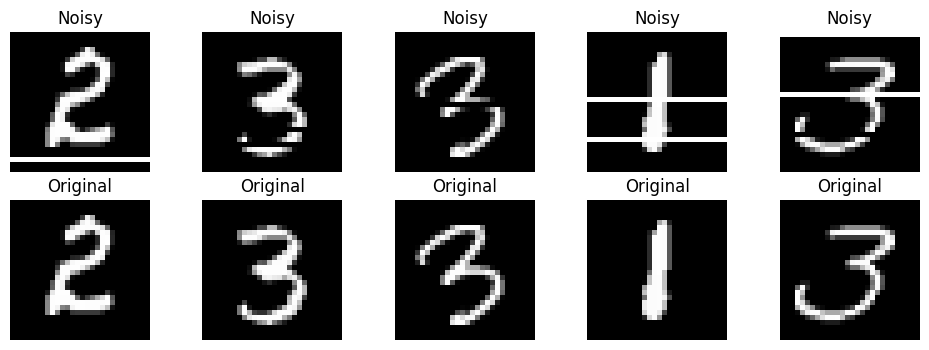

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot images
def plot_images(images, labels, num_images=5):
    fig, axes = plt.subplots(2, num_images, figsize=(12, 4))
    for i in range(num_images):
        original_image = images[i].squeeze().numpy()
        noisy_image = labels[i].squeeze().numpy()

        axes[0, i].imshow(original_image, cmap='gray')
        axes[0, i].set_title("Noisy")
        axes[0, i].axis('off')

        axes[1, i].imshow(noisy_image, cmap='gray')
        axes[1, i].set_title("Original")
        axes[1, i].axis('off')
    plt.show()

# Get a batch of images from the train loader
images, labels = next(iter(train_loader))

# Plot original and noisy images
plot_images(images, labels)

In [ ]:
### Implement your code here ####

In [ ]:
### TESTING ####

import matplotlib.pyplot as plt

# Test the model on 10 images from the validation set
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        for i in range(outputs.size(0)):
            # Plot original and reconstructed images side by side
            fig, axes = plt.subplots(1, 2, figsize=(8, 4))
            original_image = images[i].cpu().squeeze().numpy()
            reconstructed_image = outputs[i].cpu().squeeze().numpy()

            axes[0].imshow(original_image, cmap='gray')
            axes[0].set_title("Original Image")
            axes[0].axis('off')

            axes[1].imshow(reconstructed_image, cmap='gray')
            axes[1].set_title("Reconstructed Image")
            axes[1].axis('off')

            plt.show()

print("Reconstruction of test images complete.")